In [30]:
import pandas as pd
combined_df = pd.read_excel('combined_df.xlsx')


In [31]:
combined_df = combined_df.dropna(subset=['translated'])
combined_df.reset_index(drop=True,inplace=True)

In [32]:
from nltk.corpus import stopwords
additional_stop = ['nya','yg','ga','gk','tp','nih','noh','lah','dong','pa','yuk','gak','ya','sih','yaa','aja', 'min', 'bca','brimo','biar','kak','blu','mega','allo','bank','bca','btn']
all_stopwords = stopwords.words('indonesian') + additional_stop

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X=combined_df['translated']
y=combined_df['Label']
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.20,random_state=30)

In [34]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [35]:
training_ratings = le.fit_transform(y_train)
val_ratings = le.transform(y_test)

In [36]:
val_ratings

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [37]:
vocab_size = 10000
embedding_dim = 64
max_length = 15
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [39]:
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'bank': 2,
 'wajah': 3,
 'dengan': 4,
 'hati': 5,
 'dan': 6,
 'mata': 7,
 'ada': 8,
 'tersenyum': 9,
 'bisa': 10}

In [40]:
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[10])

[48, 32, 25, 186, 18]


In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

5
15
24
15
5
15


In [42]:
validation_sequences = tokenizer.texts_to_sequences(X_test)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

7241
(7241, 15)


In [43]:
import numpy as np
training_label_seq = np.array(y_train)
validation_label_seq = np.array(y_test)

In [44]:
np.shape(X_train)

(28961,)

In [45]:
from tensorflow import keras
import tensorflow as tf

def baseline_model():
  input_ = keras.layers.Input(1)
  embedding = keras.layers.Embedding(vocab_size, embedding_dim)(input_)
  bidirectional = keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim))(embedding)
  hidden1 = keras.layers.Dense(embedding_dim, activation='relu')(bidirectional)
  output = keras.layers.Dense(3, activation='softmax')(hidden1)
  model = keras.models.Model(inputs=[input_], outputs=[output])

  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [46]:
baseline_model = baseline_model()
baseline_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_3 (Embedding)     (None, 1, 64)             640000    
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 714499 (2.73 MB)
Trainable params: 714499 (2.73 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [47]:
num_epochs = 10
history = baseline_model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), batch_size=128)

Epoch 1/10
227/227 [==============================] - 8s 21ms/step - loss: 0.7185 - accuracy: 0.6692 - val_loss: 0.5899 - val_accuracy: 0.7449
Epoch 2/10
227/227 [==============================] - 4s 17ms/step - loss: 0.5212 - accuracy: 0.7806 - val_loss: 0.5831 - val_accuracy: 0.7491
Epoch 3/10
227/227 [==============================] - 4s 17ms/step - loss: 0.4482 - accuracy: 0.8158 - val_loss: 0.6015 - val_accuracy: 0.7502
Epoch 4/10
227/227 [==============================] - 4s 18ms/step - loss: 0.3928 - accuracy: 0.8412 - val_loss: 0.6784 - val_accuracy: 0.7455
Epoch 5/10
227/227 [==============================] - 4s 17ms/step - loss: 0.3483 - accuracy: 0.8597 - val_loss: 0.6829 - val_accuracy: 0.7355
Epoch 6/10
227/227 [==============================] - 4s 18ms/step - loss: 0.3047 - accuracy: 0.8768 - val_loss: 0.7977 - val_accuracy: 0.7289
Epoch 7/10
227/227 [==============================] - 5s 22ms/step - loss: 0.2705 - accuracy: 0.8893 - val_loss: 0.8324 - val_accuracy: 0.7250

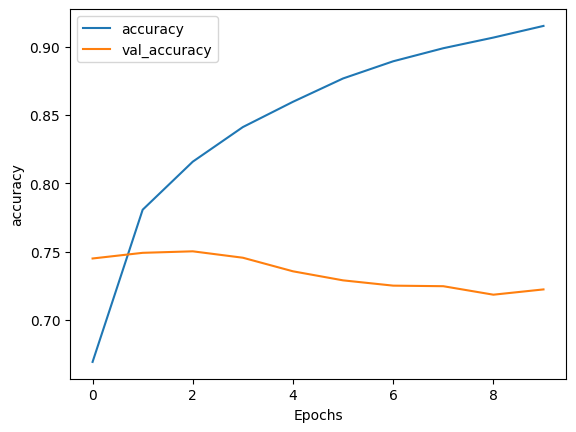

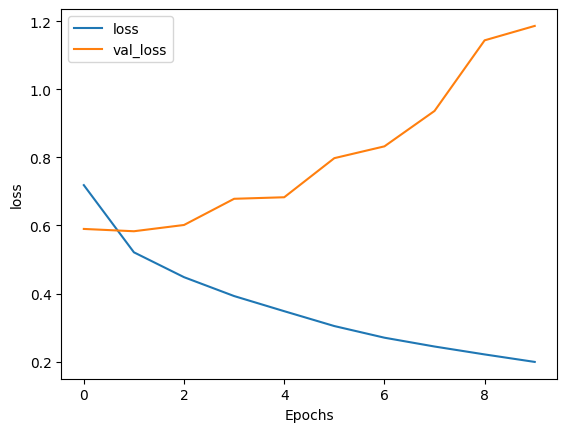

In [48]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [49]:
import tensorflow as tf
vocab_size = 10000
embedding_dim = 64
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = ''

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(128, embedding_dim, input_length=max_length, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dense(16,kernel_initializer="he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.1),bias_regularizer = tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.LeakyReLU(alpha=0.3),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(16, kernel_initializer="he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.1),
                        bias_regularizer  = tf.keras.regularizers.l2(0.01),
                        activation='elu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(8, kernel_initializer="he_normal", kernel_regularizer = tf.keras.regularizers.l2(0.1),
                        activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
  ])


opt = tf.keras.optimizers.Nadam(lr=0.0001, clipvalue=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [50]:
import tensorflow as tf
vocab_size = 10000
embedding_dim = 64
max_length = 15
trunc_type = 'post'
padding_type = 'post'
oov_tok = ''
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero=True),  # Updated vocab_size
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dense(16, kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.1), bias_regularizer=tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.LeakyReLU(alpha=0.3),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(16, kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.1),
                        bias_regularizer=tf.keras.regularizers.l2(0.01),
                        activation='elu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(8, kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.1),
                        activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])
opt = tf.keras.optimizers.Nadam(lr=0.0001, clipvalue=1.0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [51]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
checkpoint_filepath = './checkpoint_model'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), batch_size=100, callbacks=[callback, reduce_lr, model_checkpoint])

Epoch 1/30
290/290 [==============================] - 59s 148ms/step - loss: 5.1021 - accuracy: 0.6680 - val_loss: 2.7217 - val_accuracy: 0.6492 - lr: 0.0010
Epoch 2/30
290/290 [==============================] - 40s 137ms/step - loss: 1.4933 - accuracy: 0.7665 - val_loss: 1.0855 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/30
290/290 [==============================] - 40s 138ms/step - loss: 0.6924 - accuracy: 0.8124 - val_loss: 0.7121 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 4/30
290/290 [==============================] - 40s 137ms/step - loss: 0.4871 - accuracy: 0.8440 - val_loss: 0.6849 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 5/30
290/290 [==============================] - 40s 137ms/step - loss: 0.4059 - accuracy: 0.8682 - val_loss: 0.7278 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 5: early stopping


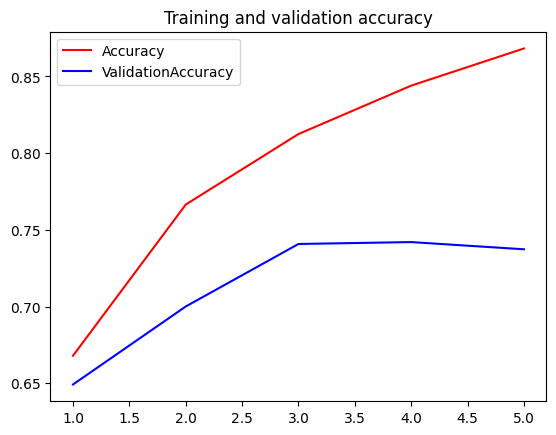

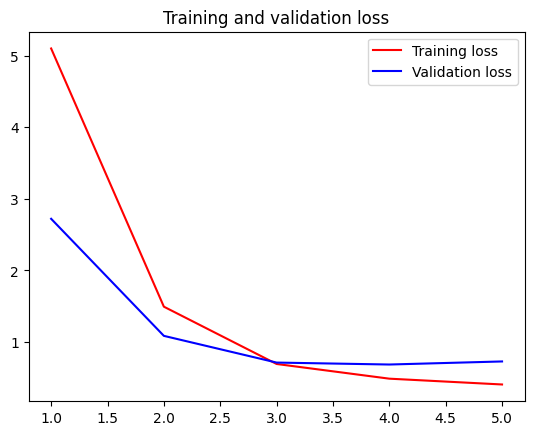

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Accuracy')
plt.plot(epochs, val_acc, 'blue', label='ValidationAccuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()